In [ ]:
from pyspark.sql.types import StructType, StringType, IntegerType, DoubleType, LongType
from pyspark.sql   import SparkSession
from pyspark.sql.functions import col , lag
from pyspark.sql.functions import to_date
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.appName('Cipla').getOrCreate()

In [ ]:
df_cipla = spark.read.format("csv").option("header","True").option("inferSchema",True).load("/content/sample_data/CIPLA .csv")

In [ ]:
cleaned_df = df_cipla.dropna()

In [ ]:
cleaned_df = spark.createDataFrame(cleaned_df.tail(cleaned_df.count() - 1), schema=cleaned_df.schema)

In [ ]:
cleaned_df.show()

+--------------------+-----------+-----------+-----------+-----------+-----------+-------+
|               Price|  Adj Close|      Close|       High|        Low|       Open| Volume|
+--------------------+-----------+-----------+-----------+-----------+-----------+-------+
|1996-01-01 00:00:...|7.302499294|8.831999779|8.833333015|8.773332596|8.778665543| 208125|
|1996-01-02 00:00:...|7.209896088|8.720000267|9.013333321|8.399999619|8.831999779|1623750|
|1996-01-03 00:00:...|7.159183025|8.658665657|8.880000114|8.626666069|8.720000267| 721875|
|1996-01-04 00:00:...|7.084218025| 8.56799984| 8.65333271|8.399999619|8.658665657| 620625|
|1996-01-05 00:00:...|7.066579819|8.546666145|8.640000343|8.506666183| 8.56799984| 350625|
|1996-01-08 00:00:...|6.945310593|8.399999619|8.520000458|8.373332977|8.546666145| 645000|
|1996-01-09 00:00:...|6.964052677|8.422665596|8.493332863|8.295999527|8.399999619| 903750|
|1996-01-10 00:00:...|7.021379948|8.491999626|8.613332748| 8.42666626|8.422665596| 455625|

In [ ]:

cleaned_df = cleaned_df.withColumnRenamed("Price","Date")


In [ ]:
cleaned_df = cleaned_df.withColumnRenamed("Adj Close","Adj_Close")

In [ ]:
cleaned_df.show()

+--------------------+-----------+-----------+-----------+-----------+-----------+-------+
|                Date|  Adj_Close|      Close|       High|        Low|       Open| Volume|
+--------------------+-----------+-----------+-----------+-----------+-----------+-------+
|1996-01-01 00:00:...|7.302499294|8.831999779|8.833333015|8.773332596|8.778665543| 208125|
|1996-01-02 00:00:...|7.209896088|8.720000267|9.013333321|8.399999619|8.831999779|1623750|
|1996-01-03 00:00:...|7.159183025|8.658665657|8.880000114|8.626666069|8.720000267| 721875|
|1996-01-04 00:00:...|7.084218025| 8.56799984| 8.65333271|8.399999619|8.658665657| 620625|
|1996-01-05 00:00:...|7.066579819|8.546666145|8.640000343|8.506666183| 8.56799984| 350625|
|1996-01-08 00:00:...|6.945310593|8.399999619|8.520000458|8.373332977|8.546666145| 645000|
|1996-01-09 00:00:...|6.964052677|8.422665596|8.493332863|8.295999527|8.399999619| 903750|
|1996-01-10 00:00:...|7.021379948|8.491999626|8.613332748| 8.42666626|8.422665596| 455625|

In [ ]:
cleaned_df = cleaned_df.withColumn("Date",to_date(cleaned_df["Date"]))



In [ ]:
cleaned_df.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|         Adj_Close|             Close|              High|               Low|             Open|            Volume|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|              7252|              7252|              7252|              7252|             7252|              7252|
|   mean| 364.3548492923415|383.53602331636347| 388.8218055427232|378.73519458649645|384.1531277447326|1661769.8798952014|
| stddev|353.59038040865664| 357.5706982323626|361.54596336059484|353.90010358851697|358.0448866711998|2141724.6277418896|
|    min|       10.01117229|       10.00399971|       10.02666569|                10|      10.00399971|                 0|
|    max|       998.9807129|       998.5499878|       999.9500122|       999.2000122|      999.9500122|            999887|
+-------+-------

In [ ]:
cleaned_df = cleaned_df.repartition(1)

# **Calculate percentage changes in Close prices day over day.**

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col

windowSpec = Window.orderBy("Date")
cleaned_df = cleaned_df.withColumn("Prev_Close", lag("Close").over(windowSpec))
cleaned_df = cleaned_df.withColumn("Daily_Return", ((col("Close") - col("Prev_Close")) / col("Prev_Close")) * 100)
cleaned_df.show(5)


+----------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+
|      Date|  Adj_Close|      Close|       High|        Low|       Open| Volume| Prev_Close|        Daily_Return|
+----------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+
|1996-01-01|7.302499294|8.831999779|8.833333015|8.773332596|8.778665543| 208125|       NULL|                NULL|
|1996-01-02|7.209896088|8.720000267|9.013333321|8.399999619|8.831999779|1623750|8.831999779| -1.2681104483981507|
|1996-01-03|7.159183025|8.658665657|8.880000114|8.626666069|8.720000267| 721875|8.720000267| -0.7033785335089302|
|1996-01-04|7.084218025| 8.56799984| 8.65333271|8.399999619|8.658665657| 620625|8.658665657| -1.0471107280450527|
|1996-01-05|7.066579819|8.546666145|8.640000343|8.506666183| 8.56799984| 350625| 8.56799984|-0.24899271006523419|
+----------+-----------+-----------+-----------+-----------+-----------+-------+--------

# **Compute 10-day and 30-day moving averages for trend analysis.**

In [ ]:
from pyspark.sql.functions import avg

cleaned_df = cleaned_df.withColumn("10_MovingAvg", avg("Close").over(windowSpec.rowsBetween(-9, 0)))
cleaned_df = cleaned_df.withColumn("30_MovingAvg", avg("Close").over(windowSpec.rowsBetween(-29, 0)))


In [ ]:
cleaned_df.show(5)

+----------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+-----------------+-----------------+
|      Date|  Adj_Close|      Close|       High|        Low|       Open| Volume| Prev_Close|        Daily_Return|     10_MovingAvg|     30_MovingAvg|
+----------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+-----------------+-----------------+
|1996-01-01|7.302499294|8.831999779|8.833333015|8.773332596|8.778665543| 208125|       NULL|                NULL|      8.831999779|      8.831999779|
|1996-01-02|7.209896088|8.720000267|9.013333321|8.399999619|8.831999779|1623750|8.831999779| -1.2681104483981507|      8.776000023|      8.776000023|
|1996-01-03|7.159183025|8.658665657|8.880000114|8.626666069|8.720000267| 721875|8.720000267| -0.7033785335089302|8.736888567666666|8.736888567666666|
|1996-01-04|7.084218025| 8.56799984| 8.65333271|8.399999619|8.658665657| 620625|8.658665657| -1.0471

# **Measure the daily range between High and Low prices.**

In [ ]:
cleaned_df = cleaned_df.withColumn("Volatility", col("High") - col("Low"))


In [ ]:
cleaned_df.show(5)

+----------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+-----------------+-----------------+-------------------+
|      Date|  Adj_Close|      Close|       High|        Low|       Open| Volume| Prev_Close|        Daily_Return|     10_MovingAvg|     30_MovingAvg|         Volatility|
+----------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+-----------------+-----------------+-------------------+
|1996-01-01|7.302499294|8.831999779|8.833333015|8.773332596|8.778665543| 208125|       NULL|                NULL|      8.831999779|      8.831999779|0.06000041899999964|
|1996-01-02|7.209896088|8.720000267|9.013333321|8.399999619|8.831999779|1623750|8.831999779| -1.2681104483981507|      8.776000023|      8.776000023| 0.6133337019999985|
|1996-01-03|7.159183025|8.658665657|8.880000114|8.626666069|8.720000267| 721875|8.720000267| -0.7033785335089302|8.736888567666666|8.736888567666666| 

# **Calculate cumulative returns over time.**

In [ ]:
from pyspark.sql.functions import sum

cleaned_df = cleaned_df.withColumn("Cumulative_Return", sum("Daily_Return").over(windowSpec))


In [ ]:
cleaned_df.show(5)

+----------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+-----------------+-----------------+-------------------+-------------------+
|      Date|  Adj_Close|      Close|       High|        Low|       Open| Volume| Prev_Close|        Daily_Return|     10_MovingAvg|     30_MovingAvg|         Volatility|  Cumulative_Return|
+----------+-----------+-----------+-----------+-----------+-----------+-------+-----------+--------------------+-----------------+-----------------+-------------------+-------------------+
|1996-01-01|7.302499294|8.831999779|8.833333015|8.773332596|8.778665543| 208125|       NULL|                NULL|      8.831999779|      8.831999779|0.06000041899999964|               NULL|
|1996-01-02|7.209896088|8.720000267|9.013333321|8.399999619|8.831999779|1623750|8.831999779| -1.2681104483981507|      8.776000023|      8.776000023| 0.6133337019999985|-1.2681104483981507|
|1996-01-03|7.159183025|8.658665657|8.880000114|8.

The above two graphs show the stock performance of Cipla over time with three key lines:

**Close Price (Green Line):**
This represents the daily closing price of Cipla's stock. Over the years, it shows a steady increase, meaning the stock price has generally gone up.

**10-Day Moving Average (Orange Line):**
This line shows the average of the last 10 days' closing prices, helping smooth out the daily ups and downs to highlight short-term trends.

**30-Day Moving Average (Red Line):**
This line is like the 10-day average but looks at a longer period of 30 days, showing the overall direction of the stock in the long term.
Key Takeaways:

**Volatility:** In the earlier years (1996-2010), the stock price (green line) shows more ups and downs, meaning there was higher volatility.

**Overall Growth:** The stock price has been rising steadily, and both the 10-day and 30-day averages follow this upward trend.

**Recent Performance:** Since around 2020, the stock price and both moving averages show a sharp increase, indicating strong recent growth.

**Conclusion:**
The graph tells us that Cipla's stock price has steadily grown over time, with some ups and downs in the early years. In recent years, the price has been rising quickly, making the stock more stable and less volatile.

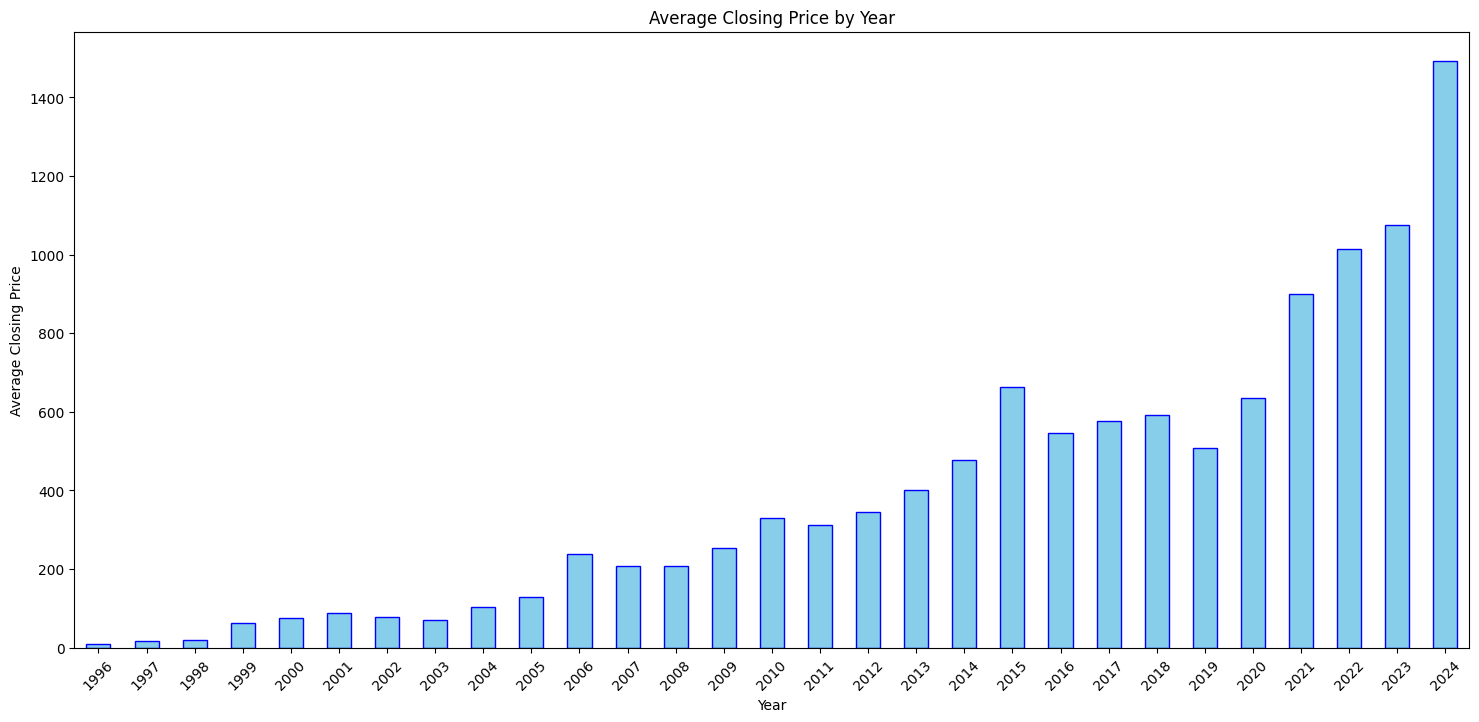

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming cleaned_df is a PySpark DataFrame, convert it to Pandas
pandas_df = cleaned_df.toPandas()

# Ensure 'Date' is in datetime format
pandas_df["Date"] = pd.to_datetime(pandas_df["Date"])

# Convert 'Close' to numeric, replacing invalid entries with NaN
pandas_df["Close"] = pd.to_numeric(pandas_df["Close"], errors="coerce")

# Drop rows with NaN in 'Close'
pandas_df = pandas_df.dropna(subset=["Close"])

# Extract the year from the 'Date' column
pandas_df["Year"] = pandas_df["Date"].dt.year

# Group by 'Year' and calculate the average closing price
average_closing_price = pandas_df.groupby("Year")["Close"].mean()

# Plot a bar graph
plt.figure(figsize=(18, 8))
average_closing_price.plot(kind="bar", color="skyblue", edgecolor="blue")

# Add titles and labels
plt.title("Average Closing Price by Year")
plt.xlabel("Year")
plt.ylabel("Average Closing Price")
plt.xticks(rotation=45)
plt.show()


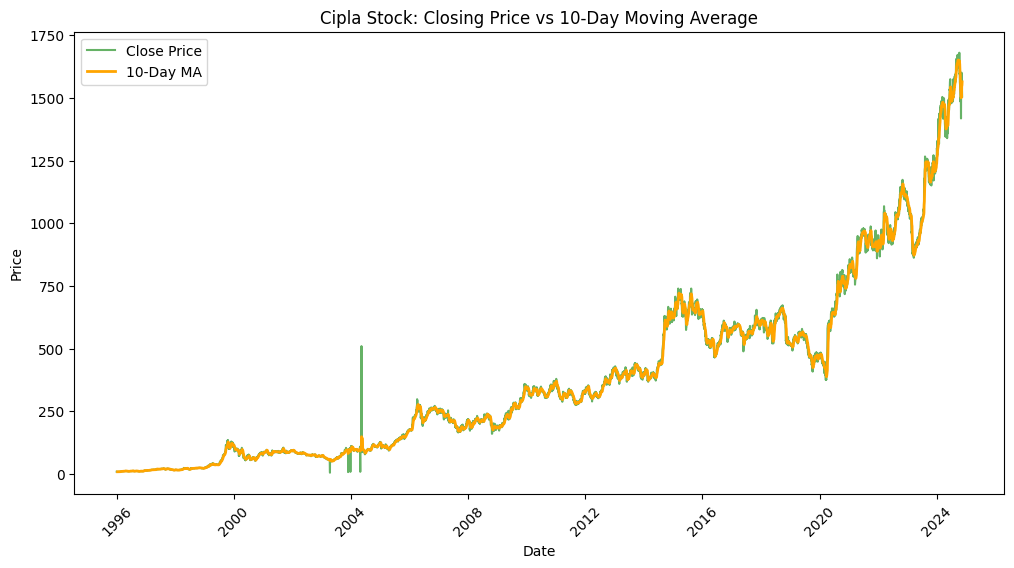

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming cleaned_df is a PySpark DataFrame, convert it to Pandas
pandas_df = cleaned_df.toPandas()

# Ensure 'Date' is in datetime format
pandas_df["Date"] = pd.to_datetime(pandas_df["Date"])

# Convert 'Close' to numeric, replacing invalid entries with NaN
pandas_df["Close"] = pd.to_numeric(pandas_df["Close"], errors="coerce")

# Drop rows with NaN in 'Close'
pandas_df = pandas_df.dropna(subset=["Close"])

# Calculate the 10-day moving average of 'Close'
pandas_df["10_MA"] = pandas_df["Close"].rolling(window=10).mean()

# Plot the Closing Price and 10-Day Moving Average
plt.figure(figsize=(12, 6))
plt.plot(pandas_df["Date"], pandas_df["Close"], label="Close Price", color='green', alpha=0.6)
plt.plot(pandas_df["Date"], pandas_df["10_MA"], label="10-Day MA", color='orange', linewidth=2)

# Add title and labels
plt.title("Cipla Stock: Closing Price vs 10-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


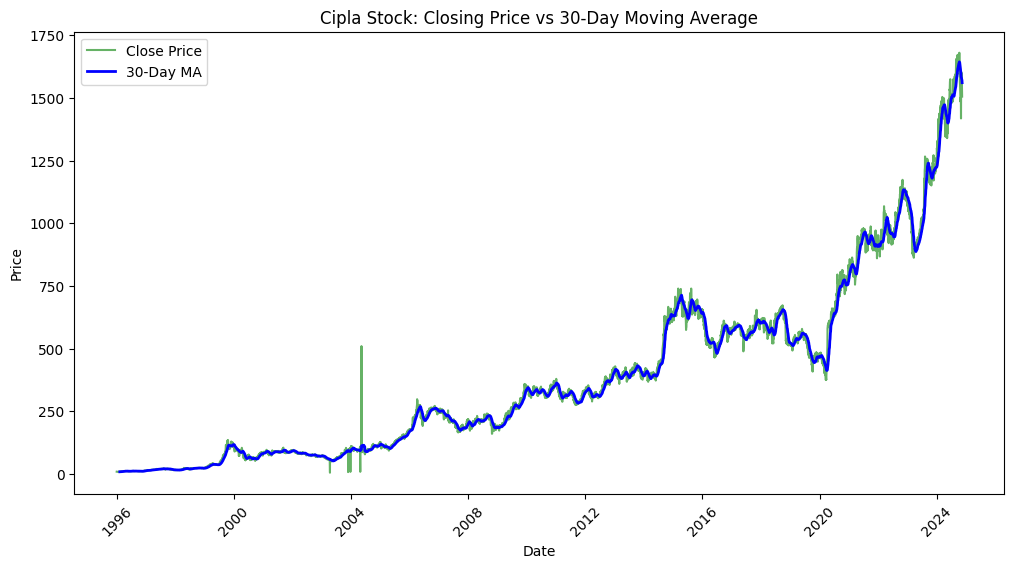

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming cleaned_df is a PySpark DataFrame, convert it to Pandas
pandas_df = cleaned_df.toPandas()

# Ensure 'Date' is in datetime format
pandas_df["Date"] = pd.to_datetime(pandas_df["Date"])

# Convert 'Close' to numeric, replacing invalid entries with NaN
pandas_df["Close"] = pd.to_numeric(pandas_df["Close"], errors="coerce")

# Drop rows with NaN in 'Close'
pandas_df = pandas_df.dropna(subset=["Close"])

# Calculate the 30-day moving average of 'Close'
pandas_df["30_MA"] = pandas_df["Close"].rolling(window=30).mean()

# Plot the Closing Price and 30-Day MA
plt.figure(figsize=(12, 6))
plt.plot(pandas_df["Date"], pandas_df["Close"], label="Close Price", color='green', alpha=0.6)
plt.plot(pandas_df["Date"], pandas_df["30_MA"], label="30-Day MA", color='blue', linewidth=2)

# Add title and labels
plt.title("Cipla Stock: Closing Price vs 30-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
cleaned_df_pandas['Date'] = pd.to_datetime(cleaned_df_pandas['Date'])


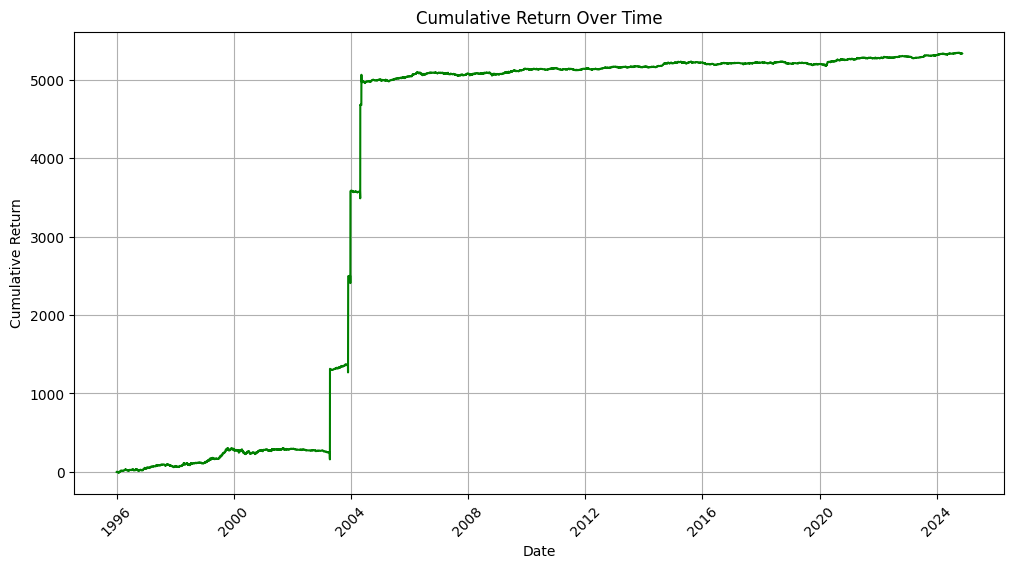

In [ ]:
#How has the cumulative return of the stock changed over time?
plt.figure(figsize=(12, 6))
plt.plot(cleaned_df_pandas['Date'], cleaned_df_pandas['Cumulative_Return'], color='green')
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [ ]:
# Average Close price
cleaned_df.selectExpr("avg(Close) as Average_Close").show()



+------------------+
|     Average_Close|
+------------------+
|383.53602331636347|
+------------------+



In [ ]:
from pyspark.sql.types import IntegerType

# Convert Volume column to IntegerType
cleaned_df = cleaned_df.withColumn("Volume", cleaned_df["Volume"].cast(IntegerType()))
cleaned_df.printSchema()


root
 |-- Date: date (nullable = true)
 |-- Adj_Close: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Prev_Close: string (nullable = true)
 |-- Daily_Return: double (nullable = true)
 |-- 10_MovingAvg: double (nullable = true)
 |-- 30_MovingAvg: double (nullable = true)
 |-- Volatility: double (nullable = true)
 |-- Cumulative_Return: double (nullable = true)
 |-- Year: integer (nullable = true)



In [ ]:
# Calculate total Volume per year
total_volume_per_year = cleaned_df.groupBy("Year").sum("Volume").withColumnRenamed("sum(Volume)", "Total_Volume").orderBy("Year")
total_volume_per_year.show()


+----+------------+
|Year|Total_Volume|
+----+------------+
|1996|    93018750|
|1997|    75465000|
|1998|    82963125|
|1999|   149985810|
|2000|   277453811|
|2001|   309128209|
|2002|   128613445|
|2003|   320474443|
|2004|   311117271|
|2005|   403323874|
|2006|   517599895|
|2007|   394557231|
|2008|   299257267|
|2009|   392333977|
|2010|   339060123|
|2011|   308850469|
|2012|   382836634|
|2013|   358307532|
|2014|   409596313|
|2015|   421528444|
+----+------------+
only showing top 20 rows



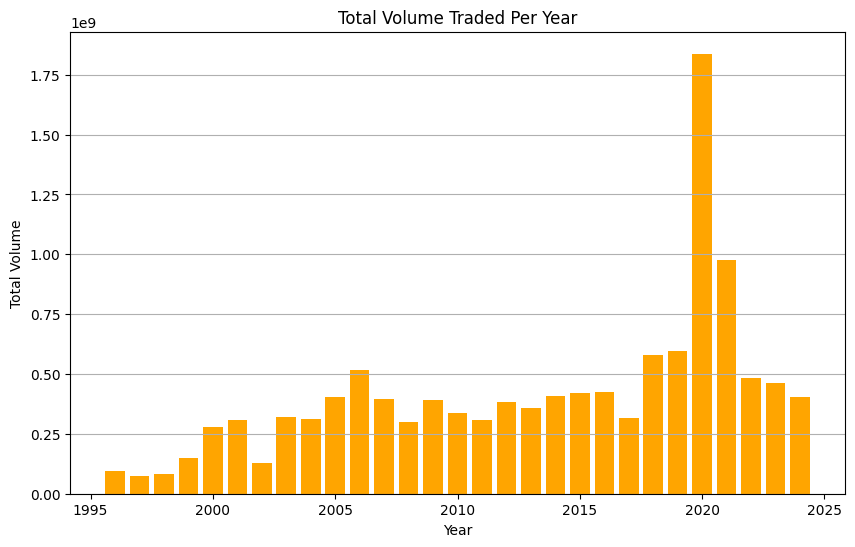

In [ ]:
# Convert to Pandas for plotting
total_volume_per_year_pd = total_volume_per_year.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(total_volume_per_year_pd['Year'], total_volume_per_year_pd['Total_Volume'], color='orange')
plt.title('Total Volume Traded Per Year')
plt.xlabel('Year')
plt.ylabel('Total Volume')
plt.grid(axis='y')
plt.show()


In [ ]:
# Calculate maximum High price per year

from pyspark.sql.types import DoubleType

# Convert Volume column to IntegerType
cleaned_df = cleaned_df.withColumn("High", cleaned_df["High"].cast(DoubleType()))

max_high_per_year = cleaned_df.groupBy("Year").max("High").withColumnRenamed("max(High)", "Max_High").orderBy("Year")
max_high_per_year.show()


+----+-----------+
|Year|   Max_High|
+----+-----------+
|1996|14.39999962|
|1997|21.86666679|
|1998|25.33066559|
|1999|146.0800018|
|2000|122.9599991|
|2001|107.1999969|
|2002|96.72000122|
|2003|107.0400009|
|2004|525.2000122|
|2005|      180.0|
|2006|      304.0|
|2007|      267.0|
|2008|244.9499969|
|2009|      363.5|
|2010|379.7999878|
|2011|      381.0|
|2012|430.1000061|
|2013|450.3999939|
|2014|      673.0|
|2015|752.8499756|
+----+-----------+
only showing top 20 rows



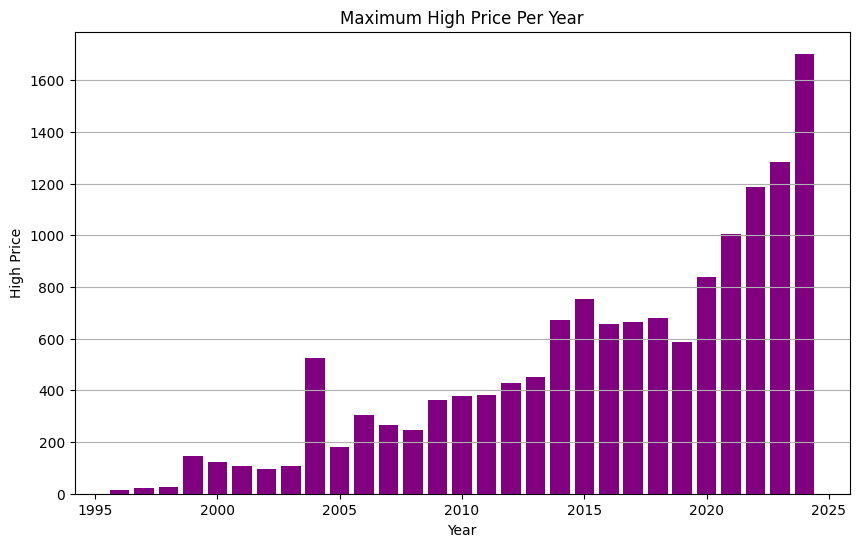

In [ ]:
# Convert to Pandas for plotting
max_high_per_year_pd = max_high_per_year.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(max_high_per_year_pd['Year'], max_high_per_year_pd['Max_High'], color='purple')
plt.title('Maximum High Price Per Year')
plt.xlabel('Year')
plt.ylabel('High Price')
plt.grid(axis='y')
plt.show()
